**План действий**
1. Применить маску к фотографиям \(убрать море, чтобы сеть быстрее обучалась\)
2. Использовать полноразмерные изображения \(выше точность\(?\)
3. SIFT / ROOTSIFT для извлечения точек
4. FAISS для сопоставления точек
5. Применить метод Keypoint Matching

![image](researchings/img.png 'Title')

Импорт библиотек

In [67]:
import tensorflow as tf
from tensorflow import keras
from pathlib import Path
import matplotlib.pyplot as plt
from keras import layers
from pathlib import Path
import numpy as np
import cv2

#tf.debugging.set_log_device_placement(True)

print('Библиотеки успешно загружены')

Библиотеки успешно загружены


Загрузить дата-сет

In [73]:
# dataset = keras.utils.image_dataset_from_directory('Whale ReId 2_mm', labels='inferred', shuffle='False', batch_size=64, interpolation='mitchellcubic',color_mode='rgb')
# masks = keras.utils.image_dataset_from_directory('Whale ReId 2_mm masked', labels='inferred', shuffle='False', batch_size=64, color_mode='grayscale')
image_size = (64, 64)
batch_size = 128

train_ds, val_ds = keras.utils.image_dataset_from_directory('Whale ReId 2_mm', labels='inferred', validation_split=0.2, subset='both', seed=1337, batch_size=batch_size, interpolation='mitchellcubic', image_size=image_size)

Found 33644 files belonging to 102 classes.
Using 26916 files for training.
Using 6728 files for validation.


Вывод

In [7]:
# from keras import layers
# # data_augmentation = keras.Sequential(
# #     [
# #         layers.RandomFlip('horizontal'),
# #         layers.RandomRotation(0.1),
# #     ]
# # )

In [55]:
def show_img(ds):
    plt.figure(figsize=(10, 10))
    for images, _ in ds.take(1):
        for i in range(9):
            # augmented_images = data_augmentation(images)
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[0].numpy().astype('uint8'))
            plt.axis('off')

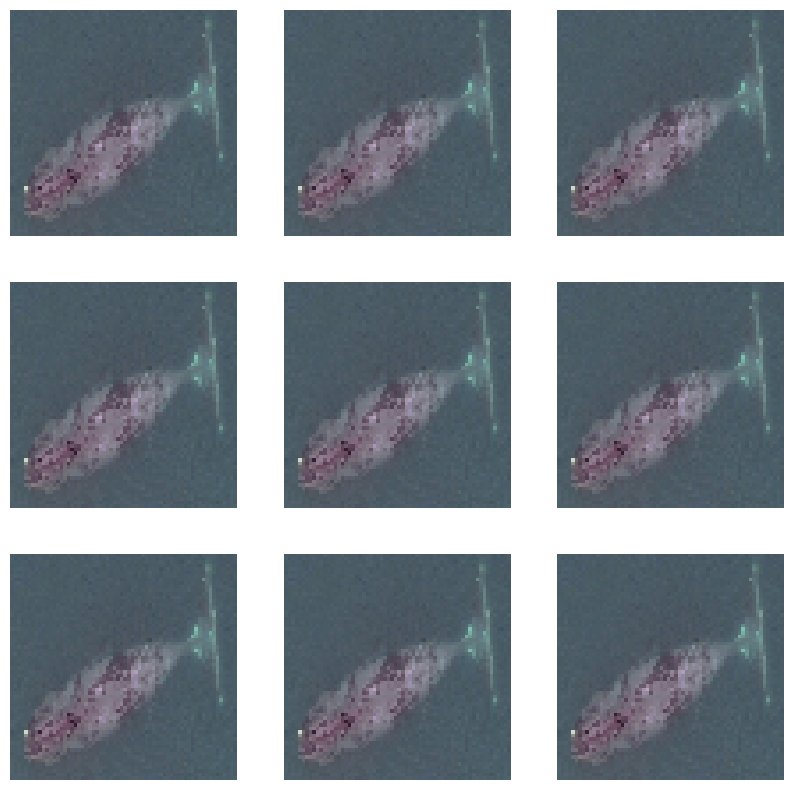

In [6]:
show_img(train_ds)

In [56]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce GTX 960, pci bus id: 0000:01:00.0, compute capability: 5.2



In [74]:
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [75]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    #x = data_augmentation(inputs)
    # Входной блок
    x = layers.Rescaling(1. / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    previous_block_activation = x

    for size in [256, 512, 728]:
        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(size, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(size, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

        residual = layers.Conv2D(size, 1, strides=2, padding='same')(
            previous_block_activation
        )
        x = layers.add([x, residual])
        previous_block_activation = x

    x = layers.SeparableConv2D(1024, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.GlobalAveragePooling2D()(x)

    activation = 'softmax'
    units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

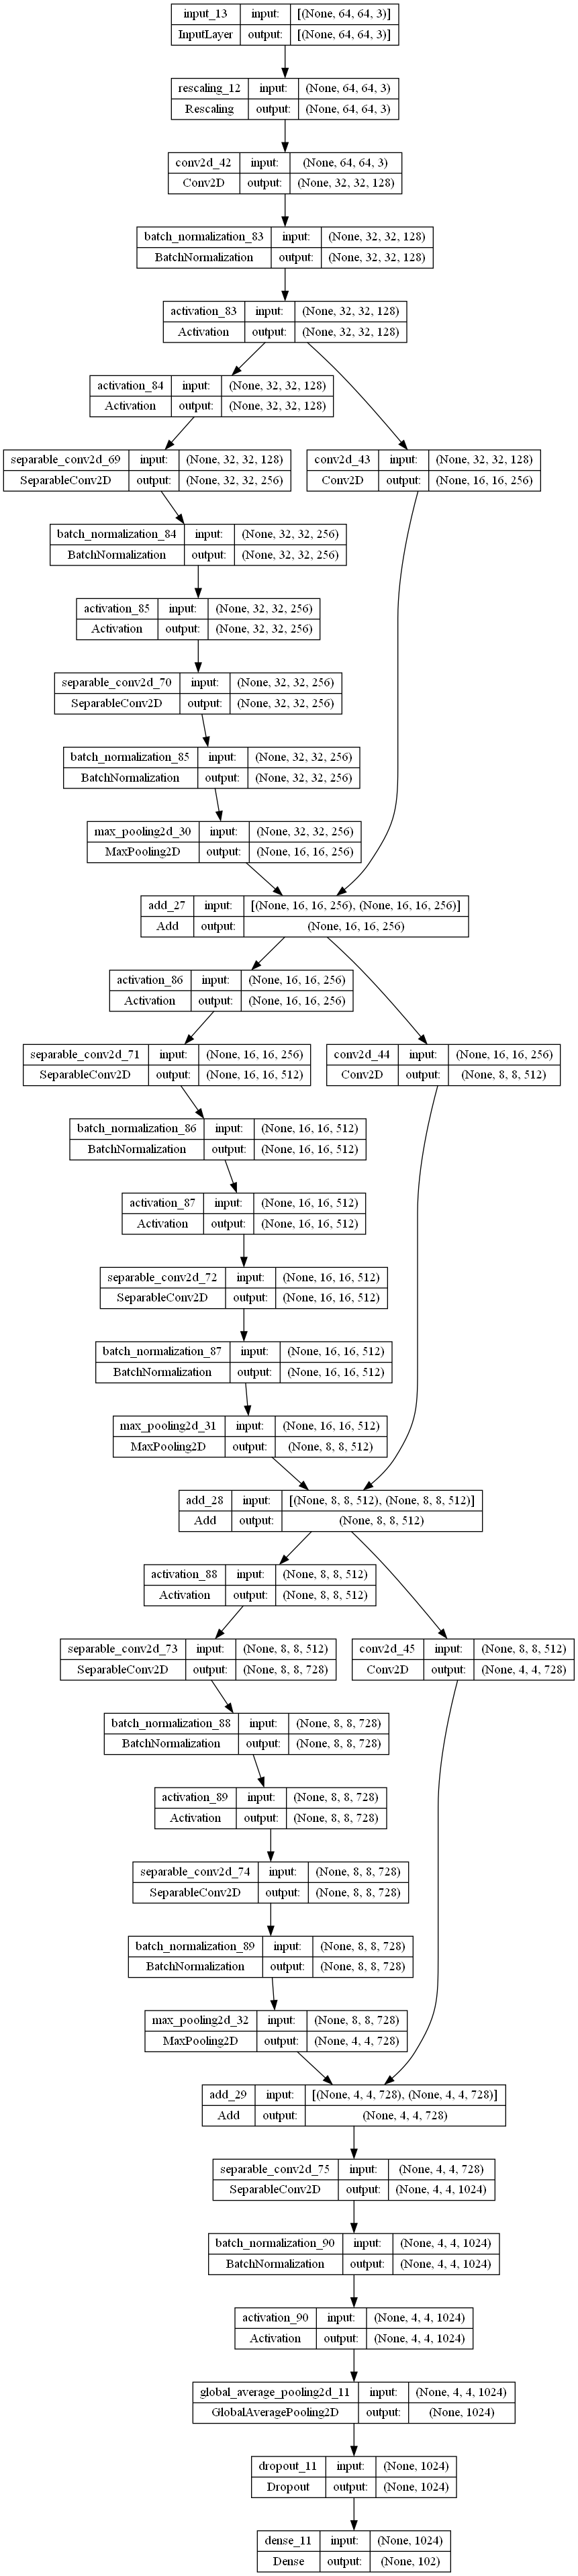

In [76]:
model = make_model(input_shape=image_size + (3,), num_classes=102)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 20

callbacks = [
    keras.callbacks.ModelCheckpoint('save_at_{epoch}.keras'),
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=2, restore_best_weights=True
    ),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss = 'SparseCategoricalCrossentropy',
    metrics = ['accuracy'],
)
history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/20
211/211 [==============================] - 132s 595ms/step - loss: 0.0190 - accuracy: 0.9947 - val_loss: 0.0925 - val_accuracy: 0.9744
Epoch 2/20
160/211 [=====================>........] - ETA: 25s - loss: 0.0403 - accuracy: 0.9889

In [78]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [25]:
img = keras.utils.load_img('test.jpg', target_size=image_size)
img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
# score = float(predictions[0])
for i in predictions[0]:
    print(f'Score {1 - i}')


1/1 [==============================] - 0s 25ms/step
Score 0.9999999997923843
Score 0.9999999999999996
Score 0.9999999999999997
Score 0.9999999999999991
Score 1.0
Score 0.9999999999999725
Score 0.9999999913855468
Score 0.9999999999999976
Score 0.9999999999711594
Score 0.9999999998749324
Score 1.0
Score 0.9999999999999999
Score 1.0
Score 0.9999999999999938
Score 0.999999998782196
Score 1.0
Score 0.9999999999999658
Score 0.9999999999999228
Score 1.0
Score 1.0
Score 1.0
Score 0.9999999999936625
Score 1.0
Score 0.9999999999995831
Score 0.9999999727571396
Score 0.9999999999994865
Score 0.9999999926937058
Score 1.0
Score 0.9999999999999901
Score 0.9999999999999818
Score 1.0
Score 0.9999999999999999
Score 0.9999999999983841
Score 0.9999999983630463
Score 0.999683500995161
Score 0.9999959386223054
Score 0.9999999987437042
Score 0.9999999999998359
Score 0.9944926658645272
Score 0.999999999999982
Score 1.0
Score 0.9999999999999986
Score 0.0059296488761901855
Score 0.999999998472491
Score 1.0
Scor

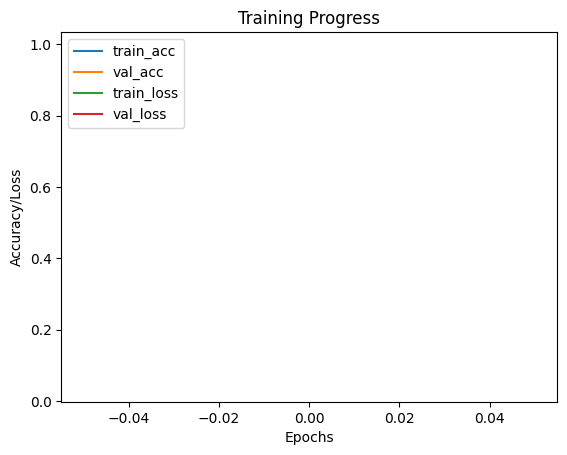

In [84]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("Training Progress")
    plt.ylabel("Accuracy/Loss")
    plt.xlabel("Epochs")
    plt.legend(["train_acc", "val_acc", "train_loss", "val_loss"], loc="upper left")
    plt.show()


plot_hist(history)